In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
df_h = pd.read_csv('../data/hollingsworth/wrangled/peers.csv', low_memory=False, index_col=0)
df_l = pd.read_csv('../data/thepeerage/wrangled/wrangled_peerage.csv', low_memory=False)


df_h1 = df_h[df_h['Extracted Parental Peerage_h'].notnull()]

In [2]:
df_h['Extracted Parental Peerage_h'].value_counts()

Extracted Parental Peerage_h
earl                       10469
baron                       9567
viscount                    3371
duke                        1451
marquess                    1090
baroness                     287
earl;earl                    139
King                          58
earl;baron                    28
baron;earl                    22
viscount;viscount             18
baron;viscount                18
Queen                         16
baroness;baron                14
earl;baroness                 12
earl;marquess                 12
earl;viscount                 11
baron;baron                   10
viscount;baron                10
baroness;earl                 10
duke;duke                      7
duke;earl                      5
baron;baroness                 5
baroness;viscount              4
duke;baron                     3
earl;duke                      3
marquess;duke                  3
viscount;baroness              2
baroness;marquess              2
duke;baroness 

In [3]:
df_l['Extracted Parental Peerage_l'].value_counts()[0:20]

Extracted Parental Peerage_l
baronet                                                    27060
baron                                                       7621
baron;baron;baronet;baronet                                 2731
baron;earl;earl;viscount;baron;viscount                     2116
life_peer                                                   1894
baron_by_writ                                               1388
baron;earl;earl;baron                                       1296
baron;viscount;viscount;baron                               1173
earl                                                         959
clan_chief                                                   779
viscount                                                     743
baron;earl;earl;baron;baron                                  723
baron;baronet;viscount;viscount;baron;baronet                601
baron;baronet;earl;earl;viscount;baron;baronet;viscount      560
baron;baron;baron                                            

In [4]:
mask = (
    df_l['Extracted Parental Peerage_l']
      .str.contains(r'\bbaron\b', regex=True, na=False)
    | df_l['Extracted Parental Peerage_l']
    .str.contains(r'\bearl\b', regex=True, na=False)
    | df_l['Extracted Parental Peerage_l']
    .str.contains(r'\bviscount\b', regex=True, na=False)
    | df_l['Extracted Parental Peerage_l']
    .str.contains(r'\bmarquess\b', regex=True, na=False)
    | df_l['Extracted Parental Peerage_l']
    .str.contains(r'\bjacobite\b', regex=True, na=False)
    | df_l['Extracted Parental Peerage_l']
    .str.contains(r'\bduke\b', regex=True, na=False)
    | df_l['Extracted Parental Peerage_l']
    .str.contains(r'\bbaron_by_writ\b', regex=True, na=False)
#    | df_l['Extracted Parental Peerage']
#    .str.contains(r'\blife_peer\b', regex=True, na=False)       # has "baron" as a full token
  &
(df_l['Extracted Parental Peerage_l']!='baronet')     # but not "baronet"
)
df_l1 = df_l.loc[mask]
df_l1 = df_l1[((df_l1['born_year_l']>=1527) & (df_l1['born_year_l']<=1945))]

<Axes: xlabel='died_year_l'>

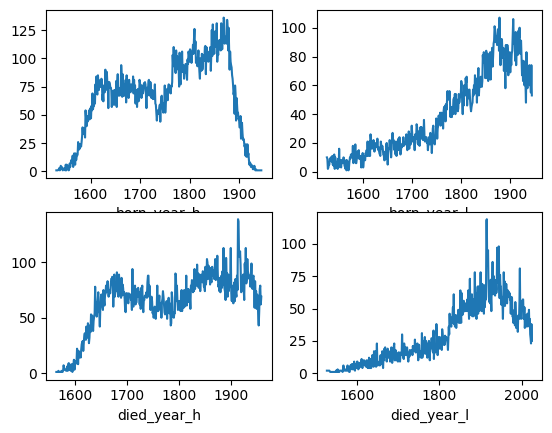

In [5]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)

df_h1['born_year_h'].value_counts().sort_index().plot(ax=ax1)
df_l1['born_year_l'].value_counts().sort_index().plot(ax=ax2)
df_h1['died_year_h'].value_counts().sort_index().plot(ax=ax3)
df_l1['died_year_l'].value_counts().sort_index().plot(ax=ax4)


In [6]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil import parser

def parse_dt(x):
    if pd.isna(x):
        return None
    try:
        return parser.parse(str(x))
    except:
        return None

def age_in_years(born, died):
    if born is None or died is None:
        return np.nan
    delta = died - born
    days  = delta.days + delta.seconds/86400
    return days / 365.2425

def compute_exact_age_column(df,
                             born_col,
                             died_col,
                             out_col='age_at_death_years'):
    born_py = df[born_col].apply(parse_dt)
    died_py = df[died_col].apply(parse_dt)
    df[out_col] = [age_in_years(b, d) for b, d in zip(born_py, died_py)]
    return df


In [7]:
df_l1 = compute_exact_age_column(df_l1, 'born_datetime_l', 'died_datetime_l')
df_h1 = compute_exact_age_column(df_h1, 'born_datetime_h', 'died_datetime_h')


/tmp/ipykernel_39779/4079539145.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[out_col] = [age_in_years(b, d) for b, d in zip(born_py, died_py)]


In [8]:
import pandas as pd

def compute_rolling_avg_age(df: pd.DataFrame, field: str, X: int, start: int = 1550, end: int = 1950) -> pd.DataFrame:
    """
    Compute X-year sliding windows of average age at death,
    robust to missing birth dates.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain:
         - 'born_datetime' (str or NA)
         - 'age_at_death_years' (float, NaN if no death date)
    X : int
        Window length in years.
    start : int, optional
        First birth-year to include (default: 1550).
    end : int, optional
        Last birth-year (exclusive) to consider starting a window (default: 1950).

    Returns
    -------
    pd.DataFrame
        Columns: ['window_start', 'window_end', 'avg_age'].
    """
    # Extract birth year, preserving NA for missing/invalid entries
    birth_year = (
        df[field]
        .where(df[field].notna())  # keep only non-NA strings
        .str[:4]                            # first 4 chars
        .astype('Int64')                    # pandas nullable integer dtype
    )

    age_exact = df['age_at_death_years']

    results = []
    for s in range(start, end - X + 1):
        mask = (birth_year >= s) & (birth_year < s + X)
        avg_age = age_exact[mask].mean()
        results.append({
            'window_start': s,
            'window_end':   s + X,
            'avg_age':      avg_age
        })

    return pd.DataFrame(results)

# Example usage:
df_roll_25_h1 = compute_rolling_avg_age(df_h1[df_h1['First Forename_h']==''], 'born_datetime_h', X=10)
df_roll_25_l1 = compute_rolling_avg_age(df_l1, 'born_datetime_l', X=10)



In [11]:
#df_h1[df_h1['First Forename_h']=='']
df_h1['First Forename_h'].value_counts(dropna=False).to_csv('FORENAME_COUNT.csv')

<Axes: xlabel='window_start'>

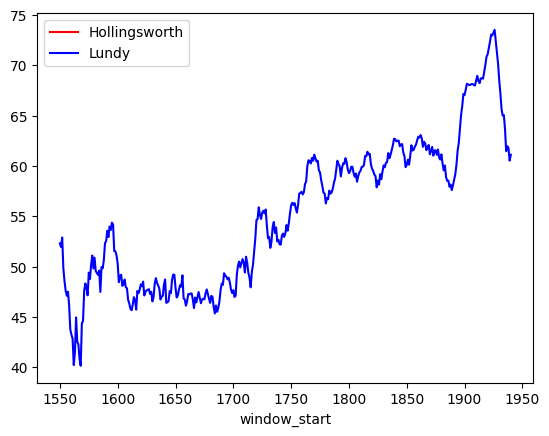

In [10]:
df_roll_25_h1.set_index('window_start')['avg_age'].plot(c='r', label='Hollingsworth', legend=True)
df_roll_25_l1.set_index('window_start')['avg_age'].plot(c='b', label='Lundy', legend=True)